# THAI cases in LFRic

## Import libraries

Standard library

In [1]:
from operator import itemgetter

External libraries

In [2]:
import iris
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnchoredText

In [3]:
from aeolus.calc import spatial_mean, zonal_mean
from aeolus.coord import ensure_bounds
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import lfric, um
from aeolus.plot import (
    cube_minmeanmax_str,
    figsave,
    linspace_pm1,
    subplot_label_generator,
    tex2cf_units,
    timeseries_1d,
)

Local modules

In [4]:
import paths
from shared import MODELS
from shared import THAI_CASES as SIM_CASES

In [5]:
plt.style.use("custom.mplstyle")
# plt.style.use("seaborn-v0_8-darkgrid")
KW_ZERO_LINE = KW_ZERO_LINE = dict(
    color="tab:grey", alpha=0.5, linestyle=":", dash_capstyle="round"
)

In [6]:
# Skip UM
_ = MODELS.pop("um")

## Load data

Load LFRic-Atmosphere data for all 4 THAI cases and store it in a dictionary

In [7]:
runs = {}
for model_key, model_prop in MODELS.items():
    model = model_prop["model"]
    runs[model_key] = {}

    for sim_label, sim_prop in SIM_CASES.items():
        dset = load_data(
            paths.data_final
            / model_key
            / sim_label
            / f"{sim_label}_{sim_prop['proc_fname_suffix']}_time_mean.nc"
        )

        runs[model_key][sim_label] = AtmoSim(
            dset,
            name=sim_label,
            vert_coord="z",
            planet=sim_prop["planet"],
            const_dir=paths.const,
            model=model,
        )

## Plots: Maps

Check what variables are available

In [8]:
[(i.var_name, i.name()) for i in runs["lfric"]["thai_hab1"]._cubes]

[('lw_up_surf', 'surface_upward_longwave_flux'),
 ('lw_up_clear_toa_rts', 'toa_upward_clear_longwave_flux_radiative_timestep'),
 ('grid_surface_temperature', 'grid_surface_temperature'),
 ('lw_down_surf', 'surface_downward_longwave_flux'),
 ('pressure_in_wth', 'pressure_at_cell_interfaces'),
 ('lw_up_toa', 'toa_upward_longwave_flux'),
 ('tot_col_m_v', 'atmosphere_mass_content_of_water_vapor'),
 ('sw_direct_toa', 'toa_direct_shortwave_flux'),
 ('tot_col_m_ci', 'atmosphere_mass_content_of_cloud_ice'),
 ('sw_up_surf', 'surface_upward_shortwave_flux'),
 ('cloud_amount_maxrnd', 'combined_cloud_amount_maximum_random_overlap'),
 ('sw_up_clear_toa_rts', 'toa_upward_clear_shortwave_flux_radiative_timestep'),
 ('sw_down_surf', 'surface_downward_shortwave_flux'),
 ('tot_col_m_cl', 'atmosphere_mass_content_of_cloud_liquid_water'),
 ('sw_up_toa', 'toa_upward_shortwave_flux'),
 ('temperature', 'air_temperature'),
 ('u_in_w3', 'eastward_wind'),
 ('v_in_w3', 'northward_wind'),
 ('w_in_wth', 'upward_ai

Define a function to collapse a cube to a lat-lon dimensions (in this case it's an empty function)

In [9]:
def reduce_to_latlon(cube, model=lfric):
    # return last_n_day_mean(cube, 610, model=model)  # 100 orbits
    return cube  # already time-averaged

Define diagnostics and their metadata

In [10]:
DIAGS = {
    "sw_down_surf": {
        "recipe": lambda cl, model: reduce_to_latlon(
            cl.extract_cube(model.sfc_dn_sw), model=model
        ),
        "title": "Downward SW Flux at the Surface",
        "tex_units": "$W$ $m^{-2}$",
        "plt_method": ["pcolormesh"],
        "kw_plt": [
            {
                "thai_ben1": {"cmap": "inferno", "vmin": 0, "vmax": 860},
                "thai_ben2": {"cmap": "inferno", "vmin": 0, "vmax": 630},
                "thai_hab1": {"cmap": "inferno", "vmin": 0, "vmax": 400},
                "thai_hab2": {"cmap": "inferno", "vmin": 0, "vmax": 300},
            },
        ],
        "add_colorbar": [True],
        "add_clabel": [False],
    },
    "lw_net_up_surf": {
        "recipe": lambda cl, model: reduce_to_latlon(
            cl.extract_cube(model.sfc_up_lw) - cl.extract_cube(model.sfc_dn_lw),
            model=model,
        ),
        "title": "Net Upward LW Flux at the Surface",
        "tex_units": "$W$ $m^{-2}$",
        "plt_method": ["pcolormesh"],
        "kw_plt": [
            {
                "thai_ben1": {"cmap": "RdYlBu_r", "vmin": -460, "vmax": 460},
                "thai_ben2": {"cmap": "RdYlBu_r", "vmin": -230, "vmax": 230},
                "thai_hab1": {"cmap": "RdYlBu_r", "vmin": -100, "vmax": 100},
                "thai_hab2": {"cmap": "RdYlBu_r", "vmin": -25, "vmax": 25},
            },
        ],
        "add_colorbar": [True],
        "add_clabel": [False],
    },
    "lw_up_toa": {
        "recipe": lambda cl, model: reduce_to_latlon(
            cl.extract_cube(model.toa_olr), model=model
        ),
        "title": "Upward LW Flux at TOA",
        "tex_units": "$W$ $m^{-2}$",
        "plt_method": ["pcolormesh"],
        "kw_plt": [
            {
                "thai_ben1": {"cmap": "inferno", "vmin": 50, "vmax": 490},
                "thai_ben2": {"cmap": "inferno", "vmin": 131, "vmax": 330},
                "thai_hab1": {"cmap": "inferno", "vmin": 100, "vmax": 250},
                "thai_hab2": {"cmap": "inferno", "vmin": 150, "vmax": 225},
            },
        ],
        "add_colorbar": [True],
        "add_clabel": [False],
    },
    "t_sfc": {
        "recipe": lambda cl, model: reduce_to_latlon(
            cl.extract_cube(model.t_sfc), model=model
        ),
        "title": "Surface Temperature",
        "tex_units": "$K$",
        "plt_method": ["pcolormesh"],
        "kw_plt": [
            {
                "thai_ben1": {"cmap": "plasma", "vmin": 150, "vmax": 320},
                "thai_ben2": {"cmap": "plasma", "vmin": 150, "vmax": 320},
                "thai_hab1": {"cmap": "plasma", "vmin": 200, "vmax": 310},
                "thai_hab2": {"cmap": "plasma", "vmin": 200, "vmax": 310},
            },
        ],
        "add_colorbar": [True],
        "add_clabel": [False],
    },
    "cloud_amount_maxrnd": {
        "recipe": lambda cl, model: reduce_to_latlon(
            cl.extract_cube(model.caf), model=model
        ),
        "title": "Cloud Fraction",
        "tex_units": "%",
        "plt_method": ["contourf"],
        "kw_plt": [
            {
                "thai_hab1": {"cmap": "Purples", "levels": np.linspace(0, 100, 11)},
                "thai_hab2": {"cmap": "Purples", "levels": np.linspace(0, 100, 11)},
            },
        ],
        "add_colorbar": [True],
        "add_clabel": [False],
    },
    "tot_col_m_ci": {
        "recipe": lambda cl, model: reduce_to_latlon(
            cl.extract_cube("tot_col_m_ci"), model=model
        ),
        "title": "Total Column Cloud Ice",
        "tex_units": "$kg$ $m^{-2}$",
        "plt_method": ["pcolormesh"],
        "kw_plt": [
            {
                "thai_hab1": {
                    "cmap": "Blues",
                    "norm": mcol.LogNorm(vmin=1e-3, vmax=1e0),
                },
                "thai_hab2": {
                    "cmap": "Blues",
                    "norm": mcol.LogNorm(vmin=1e-3, vmax=1e0),
                },
            },
        ],
        "add_colorbar": [True],
        "add_clabel": [False],
    },
    "tot_col_m_cl": {
        "recipe": lambda cl, model: reduce_to_latlon(
            cl.extract_cube("tot_col_m_cl"), model=model
        ),
        "title": "Total Column Cloud Liquid",
        "tex_units": "$kg$ $m^{-2}$",
        "plt_method": ["pcolormesh"],
        "kw_plt": [
            {
                "thai_hab1": {
                    "cmap": "Greens",
                    "norm": mcol.LogNorm(vmin=1e-3, vmax=1e0),
                },
                "thai_hab2": {
                    "cmap": "Greens",
                    "norm": mcol.LogNorm(vmin=1e-3, vmax=1e0),
                },
            },
        ],
        "add_colorbar": [True],
        "add_clabel": [False],
    },
    "tot_col_m_cil": {
        "recipe": lambda cl, model: reduce_to_latlon(
            sum(cl.extract_cubes(["tot_col_m_ci", "tot_col_m_cl"])), model=model
        ),
        "title": "Total Column Cloud Water",
        "tex_units": "$kg$ $m^{-2}$",
        "plt_method": ["pcolormesh"],
        "kw_plt": [
            {
                "thai_hab1": {
                    "cmap": "Blues",
                    "norm": mcol.LogNorm(vmin=1e-3, vmax=1e0),
                },
                "thai_hab2": {
                    "cmap": "Blues",
                    "norm": mcol.LogNorm(vmin=1e-3, vmax=1e0),
                },
            },
        ],
        "add_colorbar": [True],
        "add_clabel": [False],
    },
    "tot_col_m_v": {
        "recipe": lambda cl, model: reduce_to_latlon(
            cl.extract_cube("tot_col_m_v"), model=model
        ),
        "title": "Total Column Water Vapour",
        "tex_units": "$kg$ $m^{-2}$",
        "plt_method": ["pcolormesh"],
        "kw_plt": [
            {
                "thai_hab1": {
                    "cmap": "BuPu",
                    "norm": mcol.LogNorm(vmin=1e-1, vmax=1e2),
                },
                "thai_hab2": {
                    "cmap": "BuPu",
                    "norm": mcol.LogNorm(vmin=1e-1, vmax=1e2),
                },
            },
        ],
        "add_colorbar": [True],
        "add_clabel": [False],
    },
}

Select variables and cases to plot, etc

In [11]:
show_cases = []
show_cases += ["thai_ben1", "thai_ben2"]
show_cases += ["thai_hab1", "thai_hab2"]
# show_diags = ["sw_down_surf", "lw_net_up_surf", "lw_up_toa"]
# show_diags = ["tot_col_m_v", "tot_col_m_ci", "tot_col_m_cl", "cloud_amount_maxrnd"]
show_diags = ["t_sfc"]
plot_winds = "quiver"  # "streamplot"
# plot_winds = None
save_fig = True
fmt = "auto"
# fmt = "pretty"
model_key = "lfric"
model_prop = MODELS[model_key]
height_constraint = iris.Constraint(**{model_prop["model"].z: 8000})

Assemble the figure

Saved to ../figures/thai__lfric__thai_ben1_thai_ben2_thai_hab1_thai_hab2__map__t_sfc_wind_at_08000m.png


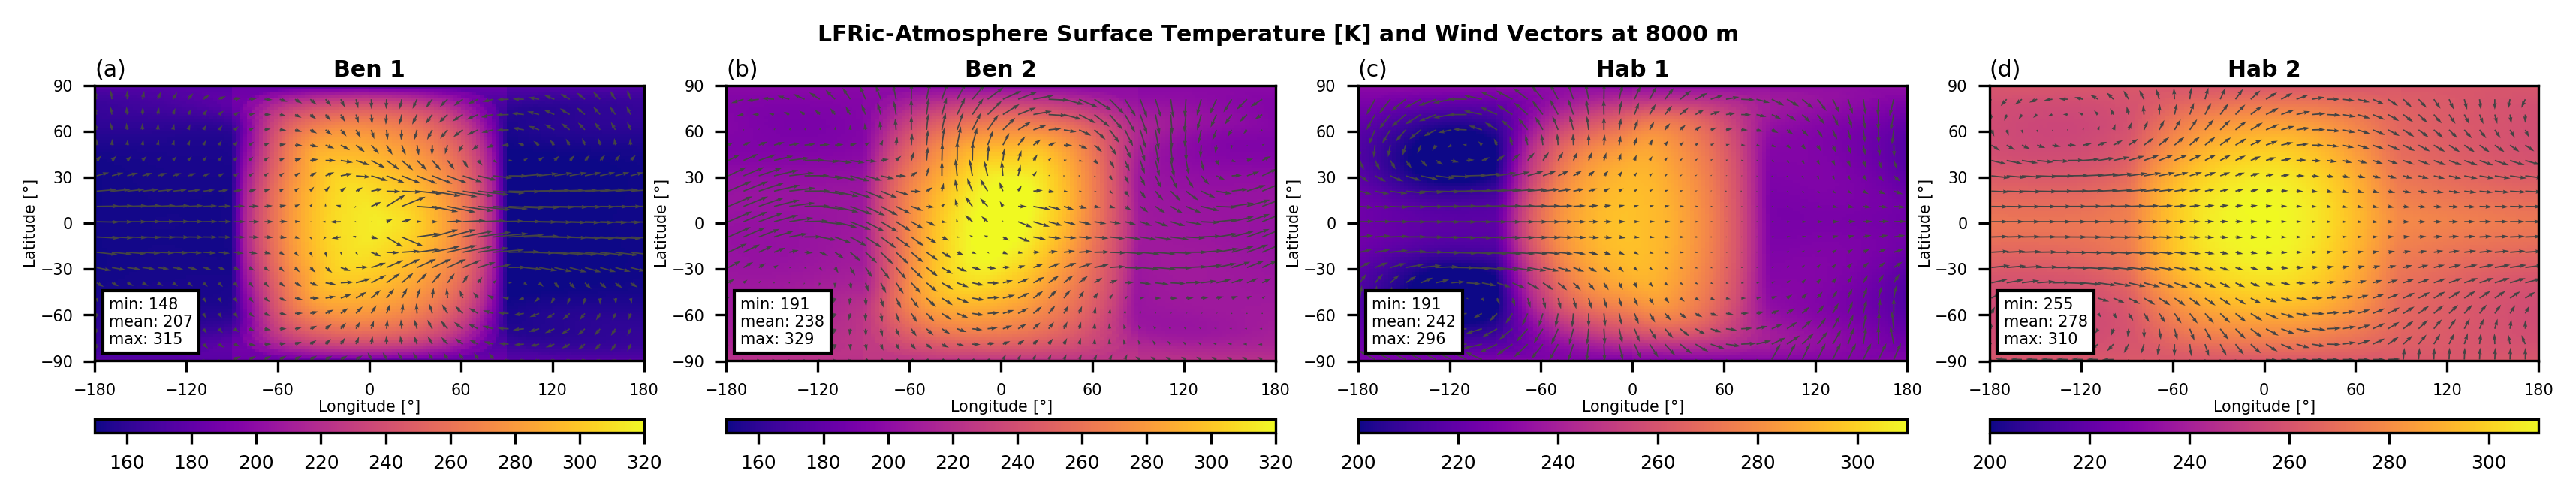

In [12]:
fig = plt.figure(figsize=(3.5 * len(show_cases), 2 * len(show_diags)))
iletters = subplot_label_generator()

subfigs = fig.subfigures(nrows=len(show_diags), ncols=1, squeeze=False)
for ndiag, (show_diag, subfig) in enumerate(zip(show_diags, subfigs[:, 0])):
    diag_prop = DIAGS[show_diag]
    # axs = subfig.subplots(nrows=1, ncols=len(show_cases))
    axd = subfig.subplot_mosaic(
        [show_cases] + [[f"{show_case}-cax" for show_case in show_cases]],
        gridspec_kw={"wspace": 0.15, "hspace": 0.4, "height_ratios": [1, 0.05]},
    )
    tex_units = diag_prop["tex_units"]
    ttl = model_prop["title"]
    ttl += f" {diag_prop['title']}"
    if tex_units != "1":
        ttl += f" [{tex_units}]"

    for ncase, show_case in enumerate(show_cases):
        ax = axd[show_case]
        cax = axd[f"{show_case}-cax"]

        ax.set_title(f"({next(iletters)})", loc="left")
        ax.set_yticks(np.arange(-90, 91, 30))
        ax.set_ylim(-90, 90)
        ax.set_xticks(np.arange(-180, 181, 60))
        ax.set_xlim(-180, 180)
        ax.tick_params(labelsize="small")
        # if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Longitude [$\degree$]", size="small", labelpad=0)
        # if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Latitude [$\degree$]", size="small", labelpad=0)

        if ax.get_subplotspec().is_first_row():
            ax.set_title(
                SIM_CASES[show_case]["title"],
                loc="center",
                fontdict={"fontweight": "bold"},
                pad=3,
            )

        cube = diag_prop["recipe"](
            runs[model_key][show_case]._cubes, model=model_prop["model"]
        )
        cube.convert_units(tex2cf_units(tex_units))
        x = cube.coord(model_prop["model"].x).points
        y = cube.coord(model_prop["model"].y).points
        z = cube.data

        plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
        for plt_method, kw_plt, add_colorbar, add_clabel in zip(*plt_items(diag_prop)):
            pic = getattr(ax, plt_method)(x, y, z, **kw_plt[show_case])
            if add_colorbar:
                fig.colorbar(pic, cax=cax, orientation="horizontal")
            if add_clabel:
                ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
            ax.add_artist(
                AnchoredText(
                    cube_minmeanmax_str(
                        cube,
                        fmt=fmt,
                        precision=1,
                        sep="\n",
                        eq_sign=": ",
                    ),
                    loc="lower left",
                    frameon=True,
                    prop={"size": "small"},
                )
            )

        if plot_winds:
            u = reduce_to_latlon(runs[model_key][show_case].u)
            v = reduce_to_latlon(runs[model_key][show_case].v)
            for cube in [u, v]:
                ensure_bounds(cube, coords=("z"), model=model)
            u = u.extract(height_constraint)
            v = v.extract(height_constraint)
            rounded_height = round(u.coord(model.z).points[0])
            extra_label = f"_wind_at_{rounded_height:05d}m"

            if plot_winds == "quiver":
                xsl, ysl = slice(None, None, 4), slice(None, None, 5)
                ax.quiver(
                    x[xsl],
                    y[ysl],
                    u.data[ysl, xsl],
                    v.data[ysl, xsl],
                    color="#444444",
                )
            elif plot_winds == "streamplot":
                wspd = (u**2 + v**2) ** 0.5
                ax.streamplot(
                    x,
                    y,
                    u.data,
                    v.data,
                    color="#444444",
                    linewidth=2 * wspd.data / wspd.data.max(),
                    arrowstyle="fancy",
                )
        else:
            extra_label = ""
    if plot_winds:
        ttl += f" and Wind Vectors at {rounded_height} m"
    subfig.suptitle(ttl, y=1.02, fontweight="bold")

if save_fig:
    figsave(
        fig,
        paths.figures
        / f"thai__{model_key}__{'_'.join(show_cases)}__map__{'_'.join(show_diags)}{extra_label}",
    )

## Plots: Zonal Cross-Sections

Define the function to collapse a cube to a z-y (height-latitude) dimensions

In [13]:
def reduce_to_heightlat(cube, model=lfric):
    # return last_n_day_mean(
    #     zonal_mean(cube, model=model), 610, model=model
    # )  # 100 orbits
    return zonal_mean(cube, model=model)

Define diagnostics and their metadata

In [14]:
DIAGS = {
    "u": {
        "recipe": lambda cl, model: reduce_to_heightlat(
            cl.extract_cube(model.u), model=model
        ),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {
                "any": {
                    "cmap": "RdBu_r",
                    "levels": np.arange(-70, 71, 10),
                    "extend": "both",
                },
            },
            {
                "any": {
                    "colors": "k",
                    "linewidths": 0.5,
                    "levels": np.arange(-200, 200, 10),
                },
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
}

Select variables and cases to plot, etc

In [15]:
show_cases = []
show_cases += ["thai_ben1", "thai_ben2"]
show_cases += ["thai_hab1", "thai_hab2"]
show_diags = ["u"]
save_fig = True
add_minmeanmax = False
model_key = "lfric"
model_prop = MODELS[model_key]

Assemble the figure

Saved to ../figures/thai__lfric__thai_ben1_thai_ben2_thai_hab1_thai_hab2__heightlat__u.png


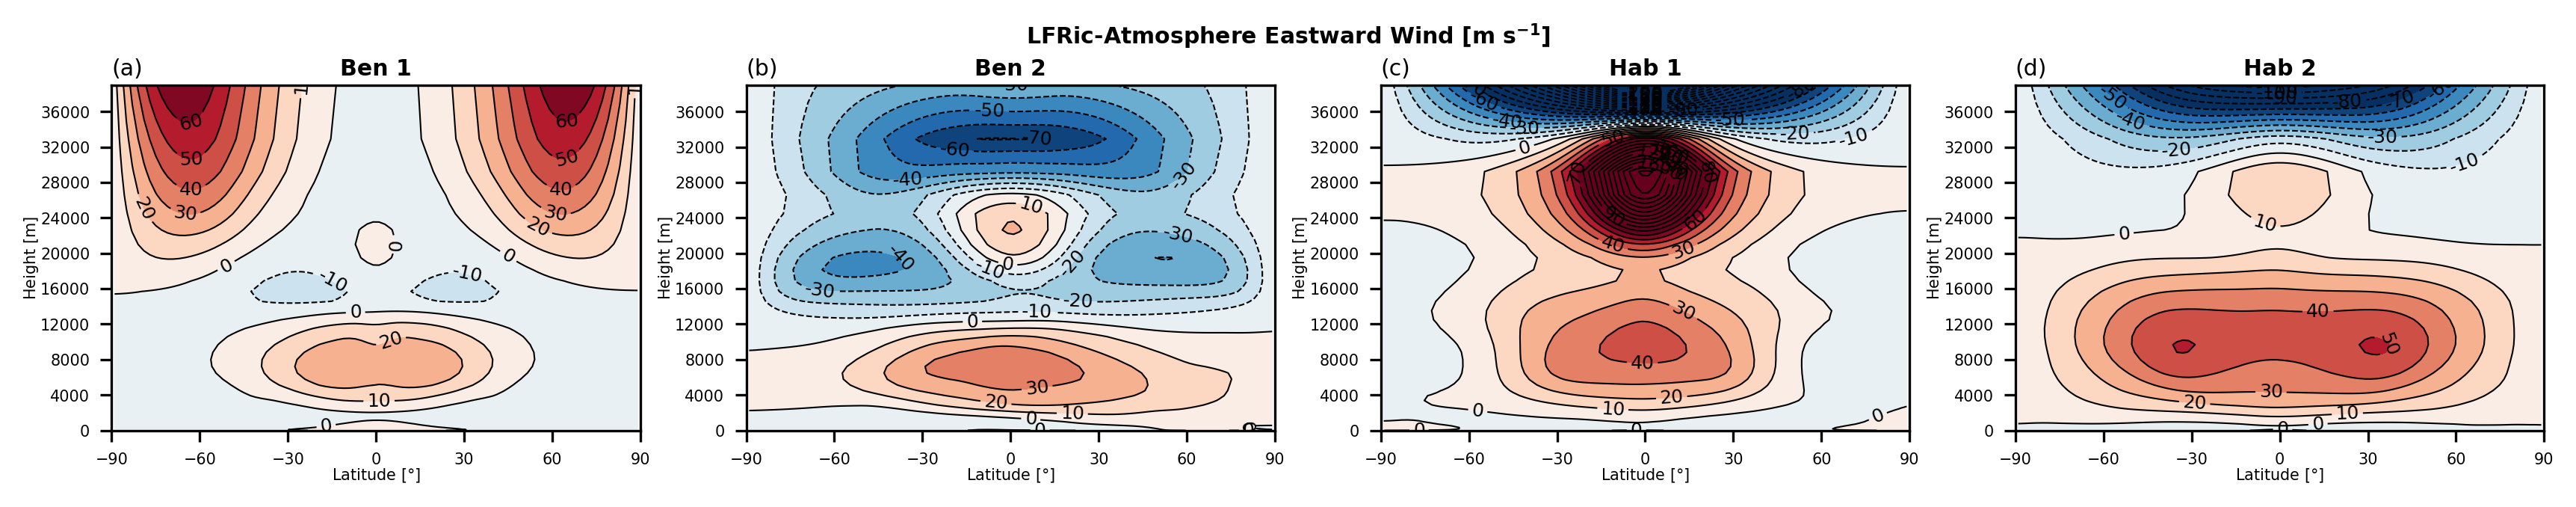

In [16]:
fig = plt.figure(figsize=(3.5 * len(show_cases), 2 * len(show_diags)))
iletters = subplot_label_generator()

subfigs = fig.subfigures(nrows=len(show_diags), ncols=1, squeeze=False)
for ndiag, (show_diag, subfig) in enumerate(zip(show_diags, subfigs[:, 0])):
    diag_prop = DIAGS[show_diag]
    add_cbar_axes = any(
        [any(DIAGS[show_diag]["add_colorbar"]) for show_diag in show_diags]
    )
    # axs = subfig.subplots(nrows=1, ncols=len(show_cases))
    if add_cbar_axes:
        axd = subfig.subplot_mosaic(
            [show_cases] + [[f"{show_case}-cax" for show_case in show_cases]],
            gridspec_kw={"wspace": 0.2, "hspace": 0.4, "height_ratios": [1, 0.05]},
        )
    else:
        axd = subfig.subplot_mosaic(
            [show_cases],
            gridspec_kw={"wspace": 0.2, "hspace": 0.4},
        )
    tex_units = diag_prop["tex_units"]
    ttl = model_prop["title"]
    ttl += f" {diag_prop['title']}"
    if tex_units != "1":
        ttl += f" [{tex_units}]"
    subfig.suptitle(ttl, y=1.02, fontweight="bold")

    for ncase, show_case in enumerate(show_cases):
        ax = axd[show_case]

        ax.set_title(f"({next(iletters)})", loc="left")
        ax.set_xticks(np.arange(-90, 91, 30))
        ax.set_xlim(-90, 90)
        ax.set_xlabel("Latitude [$\degree$]", size="small", labelpad=0)
        ax.set_yticks(np.arange(0, 39000, 4000))
        ax.set_ylim(0, 39000)
        ax.set_ylabel("Height [$m$]", size="small", labelpad=0)
        ax.tick_params(labelsize="small")

        if ax.get_subplotspec().is_first_row():
            ax.set_title(
                SIM_CASES[show_case]["title"],
                loc="center",
                fontdict={"fontweight": "bold"},
                pad=3,
            )

        cube = diag_prop["recipe"](
            runs[model_key][show_case]._cubes, model=model_prop["model"]
        )
        cube.convert_units(tex2cf_units(tex_units))
        x = cube.coord(model_prop["model"].y).points
        y = cube.coord(model_prop["model"].z).points
        z = cube.data

        plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
        for plt_method, kw_plt, add_colorbar, add_clabel in zip(*plt_items(diag_prop)):
            try:
                kw_plt_case = kw_plt[show_case]
            except KeyError:
                kw_plt_case = kw_plt.get("any", {})
            pic = getattr(ax, plt_method)(x, y, z, **kw_plt_case)
            if add_colorbar:
                fig.colorbar(pic, cax=axd[f"{show_case}-cax"], orientation="horizontal")
            if add_clabel:
                ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
if save_fig:
    figsave(
        fig,
        paths.figures
        / f"thai__{model_key}__{'_'.join(show_cases)}__heightlat__{'_'.join(show_diags)}",
    )

---

## Supplementary: Time series

In [ ]:
fig, ax = plt.subplots()
for model_key, model_prop in MODELS.items():
    model = model_prop["model"]
    for sim_label, sim_prop in SIM_CASES.items():
        timeseries_1d(
            spatial_mean(runs[model_key][sim_label].toa_net_energy),
            ax=ax,
            label=sim_label,
            alpha=0.5,
            **sim_prop["kw_plt"],
            **model_prop["kw_plt"]
        )
# ax.set_xlim(400, 1200)
ax.set_ylim(-10, 10)
ax.axhline(0, **KW_ZERO_LINE)
ax.legend()

In [ ]:
fig, ax = plt.subplots()
for model_key, model_prop in MODELS.items():
    model = model_prop["model"]
    for sim_label, sim_prop in SIM_CASES.items():
        timeseries_1d(
            spatial_mean(runs[model_key][sim_label].t_sfc),
            ax=ax,
            label=sim_label,
            **sim_prop["kw_plt"],
            **model_prop["kw_plt"]
        )
# ax.axhline(0, **KW_ZERO_LINE)
ax.legend()